### Extract Transform Load (ETL)

ETL is one of the first things which needs to be done in a data science project. The nature of this task highly depends on the type of data source. Whether it is relational or unstructured, enterprise data or internet data, persistent data or streaming data. This heavily influences the choice of architecture. Therefore, you must document your choice and thinking process in the Architectural Decision Document (ADD).

This task involves – as the name implies – accessing the data source, transforming it in a way it can be easily worked with and finally make it available to downstream analytics processes – either real-time streaming or batch ones.

In case of operational relational data, de-normalization usually needs to take place, for unstructured data, some feature extraction might already be appropriate and for real-time data, windows are usually created.

Please create an ETL process, document it and save this deliverable according to the naming convention of the process model.

In [1]:
!pip install tensorflow
!pip install python-mnist
!pip install Pillow
!pip install pyspark

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: Cryptograp

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import image
import tensorflow as tf
import seaborn as sns
from mnist import MNIST
import numpy as np
import PIL
from PIL import Image
import os
import matplotlib.image as mping
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from numpy import asarray
import pandas as pd

In [3]:
tf.__version__

'2.1.0'

In [4]:
PIL.__version__

'7.2.0'

## First dataset

#### 60,000 images and 10 classes, each image is 28 x 28 or represented by a 794 element array

In [ ]:
# need to download and gunzip each of the train and test images and labels

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz?raw=True
!mv train-images-idx3-ubyte.gz?raw=True train-images-idx3-ubyte.gz
!gunzip train-images-idx3-ubyte.gz
!ls -lahr train-images-idx3-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz?raw=True
!mv train-labels-idx1-ubyte.gz?raw=True train-labels-idx1-ubyte.gz
!gunzip train-labels-idx1-ubyte.gz
!ls -lahr train-labels-idx1-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz?raw=True
!mv t10k-images-idx3-ubyte.gz?raw=True t10k-images-idx3-ubyte.gz
!gunzip t10k-images-idx3-ubyte.gz
!ls -lahr t10k-images-idx3-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz?raw=True
!mv t10k-labels-idx1-ubyte.gz?raw=True t10k-labels-idx1-ubyte.gz
!gunzip t10k-labels-idx1-ubyte.gz
!ls -lahr t10k-labels-idx1-ubyte

In [5]:
# download the classmap for the first dataset, add the phonetics, and display it
# the classmap shows the classes that each written kuzushiji can be classified into
# and we add the phonetic sound that the characters makes when spoken

url = "http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist_classmap.csv"
df_classmap = pd.read_csv(url)
phonetic = ['o','ki','su','tsu','na','ha','ma','ya','re','wo']
df_classmap['phonetic'] = phonetic
df_classmap

,index,codepoint,char,phonetic
0,0,U+304A,お,o
1,1,U+304D,き,ki
2,2,U+3059,す,su
3,3,U+3064,つ,tsu
4,4,U+306A,な,na
5,5,U+306F,は,ha
6,6,U+307E,ま,ma
7,7,U+3084,や,ya
8,8,U+308C,れ,re
9,9,U+3092,を,wo


In [6]:
# create a directory and move these files into it
# then show what is in the directory

!mkdir kmnistdata
!cp t10k-images-idx3-ubyte kmnistdata/t10k-images-idx3-ubyte
!cp t10k-labels-idx1-ubyte kmnistdata/t10k-labels-idx1-ubyte
!cp train-images-idx3-ubyte kmnistdata/train-images-idx3-ubyte
!cp train-labels-idx1-ubyte kmnistdata/train-labels-idx1-ubyte
!ls -al kmnistdata

mkdir: cannot create directory ‘kmnistdata’: File exists
total 53680
drwxrwx--- 2 wsuser watsonstudio     4096 Jun  3 23:41 .
drwxr-x--- 4 wsuser watsonstudio     4096 Jun  4 01:56 ..
-rw-rw---- 1 wsuser watsonstudio  7840016 Jun  4 02:01 t10k-images-idx3-ubyte
-rw-rw---- 1 wsuser watsonstudio    10008 Jun  4 02:01 t10k-labels-idx1-ubyte
-rw-rw---- 1 wsuser watsonstudio 47040016 Jun  4 02:01 train-images-idx3-ubyte
-rw-rw---- 1 wsuser watsonstudio    60008 Jun  4 02:01 train-labels-idx1-ubyte


In [7]:
# load the data into arrays

data = MNIST('kmnistdata')
train_images, train_labels = data.load_training()
test_images, test_labels = data.load_testing()

In [8]:
print(train_labels[0])
print(train_images[0])

8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 118, 255, 255, 124, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 238, 255, 146, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 203, 255, 220, 14, 0, 0, 0, 11, 132, 95, 187, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 149, 255, 251, 66, 0, 0, 0, 7, 168, 136, 10, 223, 245, 67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 247, 255, 156, 1, 0, 0, 0, 130, 201, 9, 0, 158, 255, 170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 212, 255, 226, 22, 0, 0, 0, 79, 240, 38, 0, 0, 143, 255, 197, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 148, 255, 255, 107, 0, 0, 0, 33, 237, 121, 0, 0, 0, 144, 255, 222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 205, 255, 178, 3, 0, 0, 1, 179, 208, 5, 0, 0, 0, 126, 255, 166, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 245, 255, 76, 0, 0, 0, 124, 254, 108, 0, 0, 0, 0, 91, 255, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 255, 239, 12, 0, 0, 62, 250, 225, 8, 0, 0, 0, 0, 78, 255, 197, 0, 0, 0, 0, 0, 0, 0, 0,

In [9]:
type(train_labels)

array.array

In [10]:
type(train_images)

list

In [11]:
# the data needs to be transformed into numpy arrays for use  in the model

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [12]:
type(train_images[0])

numpy.ndarray

In [13]:
type(train_images)

numpy.ndarray

In [14]:
# the data as downloaded has two dimensions
# there are 60000 images, each image is represented
# in one dimension as 784 numbers

# (see the notebook kuzushiji.data_exp for displayed images)

train_images.shape

(60000, 784)

In [15]:
# the train_images are now a numpy array of numbers between 0 and 255
print(train_images[0])

[  0   0   0   0   0   0   0   0   0   0   0 118 255 255 124   1   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  36 238 255 146   2   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0  12 203 255 220  14   0   0
   0  11 132  95 187  95   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0 149 255 251  66   0   0   0   7 168 136  10 223 245  67   0
   0   0   0   0   0   0   0   0   0   0   0   0  51 247 255 156   1   0
   0   0 130 201   9   0 158 255 170   0   0   0   0   0   0   0   0   0
   0   0   0  11 212 255 226  22   0   0   0  79 240  38   0   0 143 255
 197   0   0   0   0   0   0   0   0   0   0   0   0 148 255 255 107   0
   0   0  33 237 121   0   0   0 144 255 222   0   0   0   0   0   0   0
   0   0   0   0   0 205 255 178   3   0   0   1 179 208   5   0   0   0
 126 255 166   0   0   0   0   0   0   0   0   0   0   0   7 245 255  76
   0   0   0 124 254 108   0   0   0   0  91 255 15

In [16]:
# we need to normalize the numpy arrays so that each number in the numpy
# array is between 0 and 1:

train_images = train_images / 255
test_images = test_images / 255

In [17]:
train_images[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.4627451 , 1.        , 1.        , 0.48627451,
       0.00392157, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.14117647, 0.93333333,
       1.        , 0.57254902, 0.00784314, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04705882, 0.79607843, 1.        , 0.8627451 , 0.05490196,
       0.        , 0.        , 0.        , 0.04313725, 0.51764

## Second dataset

#### 232,365 images, 49 classes, each image is 28 x 28 or represented by a 794 element array

In [18]:
# download the train and test labels and images, 
# which are in .npz format 

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz?raw=True
!mv k49-train-imgs.npz?raw=True k49-train-imgs.npz
!ls -lahr k49-train-imgs.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz?raw=True
!mv k49-train-labels.npz?raw=True k49-train-labels.npz
!ls -lahr k49-train-labels.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz?raw=True
!mv k49-test-imgs.npz?raw=True k49-test-imgs.npz
!ls -lahr k49-test-imgs.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz?raw=True
!mv k49-test-labels.npz?raw=True k49-test-labels.npz
!ls -lahr k49-test-labels.npz

--2021-06-04 02:01:28--  http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66117696 (63M)
Saving to: ‘k49-train-imgs.npz?raw=True’

k49-train-imgs.npz? 100%[===================>]  63.05M  8.54MB/s    in 8.3s    

2021-06-04 02:01:36 (7.62 MB/s) - ‘k49-train-imgs.npz?raw=True’ saved [66117696/66117696]

-rw-rw---- 1 wsuser watsonstudio 64M Feb  4  2019 k49-train-imgs.npz
--2021-06-04 02:01:39--  http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164485 (161K)
Saving to: ‘k49-train-labels.npz?raw=True’

k49-train-labels.np 100%[===================>] 160.63K   369

In [19]:
# we need to define a load function in order to extract the data
# from the .npz format, and then use  it to extract:

def load(f):
    return np.load(f)['arr_0']

k49_train_images = load('k49-train-imgs.npz')
k49_train_labels = load('k49-train-labels.npz')
k49_test_images = load('k49-test-imgs.npz')
k49_test_labels = load('k49-test-labels.npz')

In [20]:
# next we download the classmap for this dataset
# and add the phonetic, and display it:

url = "http://codh.rois.ac.jp/kmnist/dataset/k49/k49_classmap.csv"
df_k49_classmap = pd.read_csv(url)

k49_phonetic = ['a', 'i',  'u',  'e',  'o',\
                'ka','ki', 'ku', 'ke', 'ko',\
                'sa','shi','su', 'se', 'so',\
                'ta','chi','tsu','te', 'to',\
                'na','ni', 'nu', 'ne', 'no',\
                'ha','hi', 'fu', 'he', 'ho',\
                'ma','mi', 'mu', 'me', 'mo',\
                'ya','yu', 'yo',\
                'ra','ri', 'ru', 're', 'ro',\
                'wa','wi', 'we ','wo', 'n','iteration_mark']
print(len(k49_phonetic))
df_k49_classmap['phonetic'] = k49_phonetic
df_k49_classmap

49


,index,codepoint,char,phonetic
0,0,U+3042,あ,a
1,1,U+3044,い,i
2,2,U+3046,う,u
3,3,U+3048,え,e
4,4,U+304A,お,o
5,5,U+304B,か,ka
6,6,U+304D,き,ki
7,7,U+304F,く,ku
8,8,U+3051,け,ke
9,9,U+3053,こ,ko


In [21]:
# the data is already a numpy array
# since we pulled it out of the .nps formatted structure

type(k49_train_images)

numpy.ndarray

In [22]:
# need to check the dimensionality of the data:

k49_train_images.shape

(232365, 28, 28)

In [23]:
k49_train_labels.shape

(232365,)

In [24]:
k49_test_images.shape

(38547, 28, 28)

In [25]:
# this means we need to flatten the data
# to two dimensions

k49_train_images = np.reshape(k49_train_images, (232365, 784))
k49_test_images = np.reshape(k49_test_images, (38547, 784))

In [26]:
k49_train_images.shape

(232365, 784)

In [27]:
k49_test_images.shape

(38547, 784)

In [28]:
# the k49_train_images are now a numpy array of numbers between 0 and 255
print(k49_train_images[0])

[  0   0   0   0   0   0   0   0   0   0  69 213  39  32 193  52   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  58 235  65   0   0  64 222  15   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   8 213  59   0   0   0   9 229
  93   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  47 164   0   0   1  37  30 174  90   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0  77 132  28  84 172 252
 239 199  10   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  65 253 248 255 203 132  26 200 123  56  62  38   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1 117 150  72
   6   0   0 176 255 255 255 200   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 208 255 250 173  39
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0  15 150 246 132  48   1   0   0   0   

In [29]:
# we need to normalize the numpy arrays so that each number in the numpy
# array is between 0 and 1:

k49_train_images = k49_train_images / 255
k49_test_images = k49_test_images / 255

In [30]:
print(k49_train_images[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.27058824 0.83529412
 0.15294118 0.1254902  0.75686275 0.20392157 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.22745098 0.92156863 0.25490196 0.         0.
 0.25098039 0.87058824 0.05882353 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.03137255 0.83529412
 0.23137255 0.         0.         0.         0.03529412 0.89803922
 0.36470588 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.18431373 0.64313725 0.         0.
 0.00392157 0.14509804 0.1176470

In [31]:
# this is the format we need for the machine learning model

## The Third Dataset 

#### includes Kanji characters, this data has 3832 different classes and consists of 140,426 images, each image is 64 X 64 pixels
#### This dataset is not as processed as the other two.  It is just a bunch of png images in a directory inside an archive file.

In [32]:
# we download the archive:

!wget http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar?raw=True
!mv kkanji.tar?raw=True kkanji.tar
!ls -lahr kkanji.tar

# list the contents of the archive
# limit output to the first 70 files

!tar -tf kkanji.tar | head -70

--2021-06-04 02:01:54--  http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324290560 (309M) [application/x-tar]
Saving to: ‘kkanji.tar?raw=True’

kkanji.tar?raw=True 100%[===================>] 309.27M  8.59MB/s    in 46s     

2021-06-04 02:02:40 (6.72 MB/s) - ‘kkanji.tar?raw=True’ saved [324290560/324290560]

-rw-rw---- 1 wsuser watsonstudio 310M Dec  8  2018 kkanji.tar
kkanji2/
kkanji2/U+5B87/
kkanji2/U+5B87/72d56fcb33d10fe0.png
kkanji2/U+5B87/75f7923797777c74.png
kkanji2/U+5B87/69d6becd4f8f2d61.png
kkanji2/U+5B87/522dd01c5f9573f5.png
kkanji2/U+5B87/36aadd8d92c64049.png
kkanji2/U+5B87/58f75629e53b9e63.png
kkanji2/U+5B87/557950fbb39b019b.png
kkanji2/U+5B87/c4ca643dbc0299b6.png
kkanji2/U+5B87/02f161e7e7a3c364.png
kkanji2/U+5B87/c45553bb4a35c8d4.png
kkanji2/U+5B87/ffa955bd6cb43af

In [33]:
# extract the archive:
!tar -xf kkanji.tar

# check whats in the current working directory:
!ls -al



total 466728
drwxr-x---    4 wsuser watsonstudio      4096 Jun  4 02:02 .
drwx------    1 wsuser watsonstudio      4096 Jun  3 23:36 ..
-rw-rw----    1 wsuser watsonstudio     26841 Jun  4 01:56 codepoints.csv
-rw-rw----    1 wsuser watsonstudio  10971201 Feb  4  2019 k49-test-imgs.npz
-rw-rw----    1 wsuser watsonstudio     27450 Feb  4  2019 k49-test-labels.npz
-rw-rw----    1 wsuser watsonstudio  66117696 Feb  4  2019 k49-train-imgs.npz
-rw-rw----    1 wsuser watsonstudio    164485 Feb  4  2019 k49-train-labels.npz
drwxr-x--- 3834 wsuser watsonstudio     90112 Dec  8  2018 kkanji2
-rw-rw----    1 wsuser watsonstudio 324290560 Dec  8  2018 kkanji.tar
drwxrwx---    2 wsuser watsonstudio      4096 Jun  3 23:41 kmnistdata
-rw-rw----    1 wsuser watsonstudio   7840016 Feb  4  2019 t10k-images-idx3-ubyte
-rw-rw----    1 wsuser watsonstudio   3041136 Feb  4  2019 t10k-images-idx3-ubyte.gz
-rw-rw----    1 wsuser watsonstudio     10008 Feb  4  2019 t10k-labels-idx1-ubyte
-rw-rw----    1 wsus

In [34]:
# check the extracted png files in the newly extracted directory
# List out the first 50 folder names in the directory kkanji2
# the folder names are also the codepoint of each of the characters:

!ls kkanji2 | head -50

U+241C6
U+24FA3
U+25DA1
U+27752
U+29780
U+29DDA
U+29E75
U+4093
U+4453
U+4543
U+4572
U+4C61
U+4C99
U+4E00
U+4E01
U+4E03
U+4E07
U+4E08
U+4E09
U+4E0A
U+4E0B
U+4E0D
U+4E0E
U+4E11
U+4E14
U+4E16
U+4E17
U+4E18
U+4E19
U+4E1E
U+4E21
U+4E26
U+4E2D
U+4E32
U+4E38
U+4E39
U+4E3B
U+4E3C
U+4E42
U+4E43
U+4E45
U+4E4B
U+4E4D
U+4E4E
U+4E4F
U+4E57
U+4E58
U+4E59
U+4E5D
U+4E5E


In [35]:
# put the codepoints in a file
# let the first line of the file be name
# of the column in the dataframe we are creating
!echo codepoint > codepoints.csv
!ls kkanji2 >> codepoints.csv
!cat codepoints.csv | head -50

codepoint
U+241C6
U+24FA3
U+25DA1
U+27752
U+29780
U+29DDA
U+29E75
U+4093
U+4453
U+4543
U+4572
U+4C61
U+4C99
U+4E00
U+4E01
U+4E03
U+4E07
U+4E08
U+4E09
U+4E0A
U+4E0B
U+4E0D
U+4E0E
U+4E11
U+4E14
U+4E16
U+4E17
U+4E18
U+4E19
U+4E1E
U+4E21
U+4E26
U+4E2D
U+4E32
U+4E38
U+4E39
U+4E3B
U+4E3C
U+4E42
U+4E43
U+4E45
U+4E4B
U+4E4D
U+4E4E
U+4E4F
U+4E57
U+4E58
U+4E59
U+4E5D


In [36]:
# make sure the file codepoints.csv is in the current directory:

!ls -al

total 466728
drwxr-x---    4 wsuser watsonstudio      4096 Jun  4 02:02 .
drwx------    1 wsuser watsonstudio      4096 Jun  3 23:36 ..
-rw-rw----    1 wsuser watsonstudio     26841 Jun  4 02:02 codepoints.csv
-rw-rw----    1 wsuser watsonstudio  10971201 Feb  4  2019 k49-test-imgs.npz
-rw-rw----    1 wsuser watsonstudio     27450 Feb  4  2019 k49-test-labels.npz
-rw-rw----    1 wsuser watsonstudio  66117696 Feb  4  2019 k49-train-imgs.npz
-rw-rw----    1 wsuser watsonstudio    164485 Feb  4  2019 k49-train-labels.npz
drwxr-x--- 3834 wsuser watsonstudio     90112 Dec  8  2018 kkanji2
-rw-rw----    1 wsuser watsonstudio 324290560 Dec  8  2018 kkanji.tar
drwxrwx---    2 wsuser watsonstudio      4096 Jun  3 23:41 kmnistdata
-rw-rw----    1 wsuser watsonstudio   7840016 Feb  4  2019 t10k-images-idx3-ubyte
-rw-rw----    1 wsuser watsonstudio   3041136 Feb  4  2019 t10k-images-idx3-ubyte.gz
-rw-rw----    1 wsuser watsonstudio     10008 Feb  4  2019 t10k-labels-idx1-ubyte
-rw-rw----    1 wsus

In [37]:
# verify the file's path:

print (os.path.abspath("codepoints.csv"))

/home/wsuser/work/codepoints.csv


In [38]:
# read all the lines of the file into pandas dataframe
# including the column header which is already in the file
# display new dataframe
# here we can confirm that the data has 3832 classes

df_kanji_classmap = pd.read_csv("codepoints.csv")
df_kanji_classmap

,codepoint
0,U+241C6
1,U+24FA3
2,U+25DA1
3,U+27752
4,U+29780
...,...
3827,U+FA38
3828,U+FA45
3829,U+FA4A
3830,U+FA55


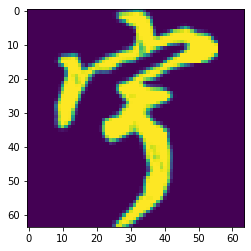

In [39]:
# we'll need to read the images in to transform them
#read the first listed image in the first folder and display it
img = mping.imread('kkanji2/U+5B87/72d56fcb33d10fe0.png')
plt.imshow(img)
plt.show()
# note that this image in only "first" as listed from the tar arcive above
# it is not "first" in terms of the codepoint listing we created directly above

In [40]:
# create a pandas dataframe that contains the codepoint for each image, 
# and its full path in the os and display that dataframe

data = []
dir = os.path.realpath('/home/wsuser/work/kkanji2')
for r, d, f in os.walk(dir):
    for file in f:
        if ".png" in file:
            data.append((r.split('/')[-1],os.path.join(r,file)))
df_kanji2 = pd.DataFrame(data, columns=['codepoint', 'image_file_path']).sort_values(by=['codepoint'], ignore_index = True)

In [41]:
# display the new dataframe
# we will change the display width of the pandas 
# dataframe to be able to see the entire path

pd.set_option('max_colwidth', 1000)
df_kanji2

,codepoint,image_file_path
0,U+241C6,/home/wsuser/work/kkanji2/U+241C6/689fa55040ec4f03.png
1,U+241C6,/home/wsuser/work/kkanji2/U+241C6/c0d603c6ce4a4538.png
2,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/4190e728bfc948e0.png
3,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/80582798ed70ce7c.png
4,U+25DA1,/home/wsuser/work/kkanji2/U+25DA1/512d7fcacddd25fd.png
...,...,...
140419,U+FA55,/home/wsuser/work/kkanji2/U+FA55/e837b009ba51dd64.png
140420,U+FA55,/home/wsuser/work/kkanji2/U+FA55/81c4ea089fd6d977.png
140421,U+FA55,/home/wsuser/work/kkanji2/U+FA55/4231e630011bf349.png
140422,U+FA5C,/home/wsuser/work/kkanji2/U+FA5C/679e4b2f026f6297.png


In [42]:
# show the os path of the first image in the first folder
# as listed in the dataframe
# note that the dataframe list the images grouped by their codepoints
# and the codepoints are sorted by their ASCII values

df_kanji2['image_file_path'][0]

'/home/wsuser/work/kkanji2/U+241C6/689fa55040ec4f03.png'

In [43]:
# read the image using Pillow and show some information about it:

pimage = Image.open(df_kanji2['image_file_path'][0])
print(pimage.format)
print(pimage.size)
print(pimage.mode)

PNG
(64, 64)
L


float32


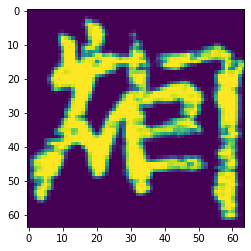

In [44]:
# read the image using matplotlib and show it
img = image.imread(df_kanji2['image_file_path'][0])
print(img.dtype)
plt.imshow(img)

In [45]:
# convert to a numpy array and verify we created a numpy array and it shape
img_nparray = asarray(img)
print(type(img_nparray))
print(img_nparray.shape)

<class 'numpy.ndarray'>
(64, 64)


In [46]:
# show the values of the array
# notice the array is already normalized
img_nparray

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.09803922, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [47]:
img_nparray.shape

(64, 64)

In [48]:
# add a blank column to the dataframe with column name 'np_array'

df_kanji2['np_array'] = ""
df_kanji2

,codepoint,image_file_path,np_array
0,U+241C6,/home/wsuser/work/kkanji2/U+241C6/689fa55040ec4f03.png,
1,U+241C6,/home/wsuser/work/kkanji2/U+241C6/c0d603c6ce4a4538.png,
2,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/4190e728bfc948e0.png,
3,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/80582798ed70ce7c.png,
4,U+25DA1,/home/wsuser/work/kkanji2/U+25DA1/512d7fcacddd25fd.png,
...,...,...,...
140419,U+FA55,/home/wsuser/work/kkanji2/U+FA55/e837b009ba51dd64.png,
140420,U+FA55,/home/wsuser/work/kkanji2/U+FA55/81c4ea089fd6d977.png,
140421,U+FA55,/home/wsuser/work/kkanji2/U+FA55/4231e630011bf349.png,
140422,U+FA5C,/home/wsuser/work/kkanji2/U+FA5C/679e4b2f026f6297.png,


In [49]:
type(df_kanji2['np_array'])


pandas.core.series.Series

In [50]:
type(df_kanji2['np_array'][0])

str

In [51]:
df_kanji2['np_array'].shape

(140424,)

In [52]:
# fire up the spark session
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [53]:
# enable arrow which lets us transfrom a pandas dataframe into a pyspark dataframe
spark.conf.set("spark.sql.execution.arrow.enabled","true")

In [54]:
# convert the pandas dataframe into a pyspark dataframe
df_kanji2_pyspk = spark.createDataFrame(df_kanji2)

In [55]:
# our data has 3,831 different classes each with unique string names
# which is based on their character codepoints
# but we want simple numeric class index
# so we instantiate a StringIndexer in spark:

indexer = StringIndexer(inputCol="codepoint",outputCol="classIndex")
indexed_df = indexer.fit(df_kanji2_pyspk).transform(df_kanji2_pyspk)
indexed_df.show()

+---------+--------------------+--------+----------+
|codepoint|     image_file_path|np_array|classIndex|
+---------+--------------------+--------+----------+
|  U+241C6|/home/wsuser/work...|        |    2606.0|
|  U+241C6|/home/wsuser/work...|        |    2606.0|
|  U+24FA3|/home/wsuser/work...|        |    2607.0|
|  U+24FA3|/home/wsuser/work...|        |    2607.0|
|  U+25DA1|/home/wsuser/work...|        |    3017.0|
|  U+27752|/home/wsuser/work...|        |    1966.0|
|  U+27752|/home/wsuser/work...|        |    1966.0|
|  U+27752|/home/wsuser/work...|        |    1966.0|
|  U+27752|/home/wsuser/work...|        |    1966.0|
|  U+27752|/home/wsuser/work...|        |    1966.0|
|  U+29780|/home/wsuser/work...|        |    3018.0|
|  U+29DDA|/home/wsuser/work...|        |    3019.0|
|  U+29E75|/home/wsuser/work...|        |    3020.0|
|   U+4093|/home/wsuser/work...|        |    3021.0|
|   U+4453|/home/wsuser/work...|        |     680.0|
|   U+4453|/home/wsuser/work...|        |     

In [56]:
# transform back to pandas dataframe:
df_kanji2 = indexed_df.toPandas()
df_kanji2

,codepoint,image_file_path,np_array,classIndex
0,U+241C6,/home/wsuser/work/kkanji2/U+241C6/689fa55040ec4f03.png,,2606.0
1,U+241C6,/home/wsuser/work/kkanji2/U+241C6/c0d603c6ce4a4538.png,,2606.0
2,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/4190e728bfc948e0.png,,2607.0
3,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/80582798ed70ce7c.png,,2607.0
4,U+25DA1,/home/wsuser/work/kkanji2/U+25DA1/512d7fcacddd25fd.png,,3017.0
...,...,...,...,...
140419,U+FA55,/home/wsuser/work/kkanji2/U+FA55/e837b009ba51dd64.png,,1041.0
140420,U+FA55,/home/wsuser/work/kkanji2/U+FA55/81c4ea089fd6d977.png,,1041.0
140421,U+FA55,/home/wsuser/work/kkanji2/U+FA55/4231e630011bf349.png,,1041.0
140422,U+FA5C,/home/wsuser/work/kkanji2/U+FA5C/679e4b2f026f6297.png,,3016.0


In [57]:
# add a column containing and numpy array of the image indicated in the path in image_file_path
# and at the same time, flatten each image from a 64 x 64 numpy array to a single
# dimension 4096 element long numpy array, and normalize it
df_kanji2['np_array'] = df_kanji2['image_file_path'].apply(lambda x: np.asarray(Image.open(x))).apply(lambda y: np.reshape(y,(4096,)))

In [58]:
# df_kanji2['np_array'] = df_kanji2['np_array'].apply(lambda z: z / 255)

In [59]:
df_kanji2

,codepoint,image_file_path,np_array,classIndex
0,U+241C6,/home/wsuser/work/kkanji2/U+241C6/689fa55040ec4f03.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",2606.0
1,U+241C6,/home/wsuser/work/kkanji2/U+241C6/c0d603c6ce4a4538.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 21, 32, 24, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 163, 206, 185, 104, 17, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",2606.0
2,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/4190e728bfc948e0.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",2607.0
3,U+24FA3,/home/wsuser/work/kkanji2/U+24FA3/80582798ed70ce7c.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",2607.0
4,U+25DA1,/home/wsuser/work/kkanji2/U+25DA1/512d7fcacddd25fd.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, ...]",3017.0
...,...,...,...,...
140419,U+FA55,/home/wsuser/work/kkanji2/U+FA55/e837b009ba51dd64.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 60, 89, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 81, 94, 169, 214, 196, 97, 27, 1, 0, 0, 0, 0, 0, 0, ...]",1041.0
140420,U+FA55,/home/wsuser/work/kkanji2/U+FA55/81c4ea089fd6d977.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 78, 158, 190, 144, 67, 23, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 16, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 29, 179, 245, 247, 233, 219, 198, 129, 21, 0, 0, 0, 0, 0, ...]",1041.0
140421,U+FA55,/home/wsuser/work/kkanji2/U+FA55/4231e630011bf349.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 37, 100, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 55, 148, 187, 134, 34, 14, 0, 0, 0, 0, 0, ...]",1041.0
140422,U+FA5C,/home/wsuser/work/kkanji2/U+FA5C/679e4b2f026f6297.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 27, 34, 50, 29, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 213, 238, 240, 243, 235, 210, 33, 1, 0, 0, ...]",3016.0


In [60]:
type(df_kanji2['np_array'])

pandas.core.series.Series

In [61]:
type(df_kanji2['np_array'][0])

numpy.ndarray

In [62]:
df_kanji2['np_array'].shape

(140424,)

In [63]:
df_kanji2['np_array'][0].shape

(4096,)